<a href="https://colab.research.google.com/github/Neulvo/TIL/blob/master/seq2seq_bi_lstm_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Concatenate

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

In [ ]:
from matplotlib import rc
from matplotlib import font_manager as fm
from matplotlib import rcParams
import matplotlib as mpl
#nanum 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
current_font()
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
#여기가 폰트 사이즈를 정하는 곳.
font_name = fm.FontProperties(fname=path, size=16).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

sys_font number: 48
nanum_font number: 31
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0
NanumBarunGothic


In [ ]:
# 파일 경로 설정
path_to_file='/content/drive/My Drive/NLP/data/kor.xlsx'

In [ ]:
# 파일 불러오기
kor_eng= pd.read_excel(path_to_file, sheet_name='Sheet1') 

In [ ]:
kor_eng

,mid_sid,ko,en
0,1,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.
1,2,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here."
2,3,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.
3,4,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.
4,5,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.
...,...,...,...
74995,74996,나의 고민은 학교가 멀어서 통학하기 힘들어.,My worry is commuting to school because it's t...
74996,74997,난 지금 내고양이때문에 충분히 힘들어.,I am going under enough difficulties because o...
74997,74998,나와 대화가 어려운 것이 많이 힘들어?,Is having difficulties in talking with me too ...
74998,74999,하루에 한번 연락하는게 그렇게 힘들어?,Is it that difficult to call once a day?


In [ ]:
 # Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  # w = unicode_to_ascii(w.lower().strip())
  w=w.lower().strip()

  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (가-힣, a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z가-힣?.!,¿]+", " ", w)
  w = w.strip()

  # adding a start and an end token to the sentence
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
def create_dataset(lines, num_examples):
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
# 순서 바꾸기
# kor_eng['ko']=kor_eng['ko'].apply(lambda x: '.'+(' '.join(x.replace('.','').split(' ')[::-1])))

In [ ]:
kor_eng['ko']

0        나는 매일 저녁 배트를 만나러 다락방으로 가요.
1                선생님 이문장이 이해가 안 가요.
2          컴퓨터를 시작하면 시간이 너무 빠르게 가요.
3             나는 오늘 자정에 한국으로 돌아 가요.
4                나는 일어나자마자 화장실에 가요.
                    ...            
74995      나의 고민은 학교가 멀어서 통학하기 힘들어.
74996         난 지금 내고양이때문에 충분히 힘들어.
74997         나와 대화가 어려운 것이 많이 힘들어?
74998         하루에 한번 연락하는게 그렇게 힘들어?
74999     어린 아이들이 스포츠를 즐기기엔 많이 힘들죠.
Name: ko, Length: 75000, dtype: object

In [ ]:
kor_eng_corp=(kor_eng['ko']+'\t'+kor_eng['en']).tolist()

In [ ]:
#확인
ko, en = create_dataset(kor_eng_corp, None)
print(ko[-1])
print(en[-1])


<start> 어린 아이들이 스포츠를 즐기기엔 많이 힘들죠 . <end>
<start> it is difficult for young children to enjoy sports . <end>


In [ ]:
# 토크나이저
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [ ]:
 def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [ ]:
# Try experimenting with the size of that dataset
num_examples = 63000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(kor_eng_corp, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
 

In [ ]:
 # Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.20633334)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


50000 50000 13000 13000


In [ ]:
def convert(lang, tensor):
 for t in tensor:
   if t!=0:
     print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
 

Input Language; index to word mapping
1 ----> <start>
11 ----> 이
7640 ----> 도면
135 ----> 들은
19 ----> 당신이
6586 ----> 요구한
66145 ----> 도면이예요
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
18 ----> this
1235 ----> drawing
9 ----> is
8 ----> a
1235 ----> drawing
19 ----> that
7 ----> you
20 ----> have
593 ----> requested
3 ----> .
2 ----> <end>


In [ ]:
# 파라미터 설정
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 1000
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
 

(TensorShape([128, 21]), TensorShape([128, 21]))

In [ ]:
 class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.initializer=tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.Bidirectional(LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer=self.initializer))
   
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state = hidden)
    output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[state_fh, state_fc, state_bh, state_bc])
    # output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[state_fh, state_fc, state_bh, state_bc])
    # output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[state_fh, state_fc, state_bh, state_bc])
    return output, state_fh, state_fc, state_bh, state_bc

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# Hidden Shape 확인
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden_fh, sample_hidden_fc, sample_hidden_bh, sample_hidden_bc = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state FH shape: (batch size, units) {}'.format(sample_hidden_fh.shape))
print ('Encoder Hidden state FC shape: (batch size, units) {}'.format(sample_hidden_fc.shape))
print ('Encoder Hidden state BH shape: (batch size, units) {}'.format(sample_hidden_bh.shape))
print ('Encoder Hidden state BC shape: (batch size, units) {}'.format(sample_hidden_bc.shape))

Encoder output shape: (batch size, sequence length, units) (128, 21, 2048)
Encoder Hidden state FH shape: (batch size, units) (128, 1024)
Encoder Hidden state FC shape: (batch size, units) (128, 1024)
Encoder Hidden state BH shape: (batch size, units) (128, 1024)
Encoder Hidden state BC shape: (batch size, units) (128, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
 def __init__(self, units):
   super(BahdanauAttention, self).__init__()
   self.W1 = tf.keras.layers.Dense(units)
   self.W2 = tf.keras.layers.Dense(units)
   self.V = tf.keras.layers.Dense(1)

 def call(self, query1, query2, values):
   # query hidden state shape == (batch_size, hidden size)
   # query_with_time_axis shape == (batch_size, 1, hidden size)
   # values shape == (batch_size, max_len, hidden size)
   # we are doing this to broadcast addition along the time axis to calculate the score
   query=Concatenate()([query1, query2])
   query_with_time_axis = tf.expand_dims(query, 1)

   # score shape == (batch_size, max_length, 1)
   # we get 1 at the last axis because we are applying score to self.V
   # the shape of the tensor before applying self.V is (batch_size, max_length, units)
   score = self.V(tf.nn.tanh(
       self.W1(query_with_time_axis) + self.W2(values)))

   # attention_weights shape == (batch_size, max_length, 1)
   attention_weights = tf.nn.softmax(score, axis=1)

   # context_vector shape after sum == (batch_size, hidden_size)
   context_vector = attention_weights * values
   context_vector = tf.reduce_sum(context_vector, axis=1)

   return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden_fh, sample_hidden_bh, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
 

Attention result shape: (batch size, units) (128, 2048)
Attention weights shape: (batch_size, sequence_length, 1) (128, 21, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.initializer=tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.Bidirectional(LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer=self.initializer))
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden_fh, hidden_fc, hidden_bh, hidden_bc, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden_fh, hidden_bh, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[hidden_fh, hidden_fc, hidden_bh, hidden_bc])
    output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[state_fh, state_fc, state_bh, state_bc])
    # output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[state_fh, state_fc, state_bh, state_bc])
    # output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[state_fh, state_fc, state_bh, state_bc])
    # state_h = Concatenate()([state_fh, state_bh])
    # state_c = Concatenate()([state_fc, state_bc])

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state_fh, state_fc, state_bh, state_bc, attention_weights
 

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden_fh,sample_hidden_fc, sample_hidden_bh, sample_hidden_bc, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
 

Decoder output shape: (batch_size, vocab size) (128, 17852)


In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.7)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
 

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder=decoder)
 

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden_fh, enc_hidden_fc, enc_hidden_bh, enc_hidden_bc = encoder(inp, enc_hidden)

    dec_hidden_fh = enc_hidden_fh
    dec_hidden_fc = enc_hidden_fc    
    dec_hidden_bh = enc_hidden_bh
    dec_hidden_bc = enc_hidden_bc

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden_fh,dec_hidden_fc, hidden_bh, hidden_bc, _ = decoder(dec_input, dec_hidden_fh,dec_hidden_fc, dec_hidden_bh, dec_hidden_bc, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  # if (epoch + 1) % 2 == 0:
  #   checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.3305
Epoch 1 Batch 100 Loss 62.5908
Epoch 1 Batch 200 Loss 49.0805
Epoch 1 Batch 300 Loss 38.8962
Epoch 1 Loss 93.9372
Time taken for 1 epoch 370.14673352241516 sec

Epoch 2 Batch 0 Loss 56.7167
Epoch 2 Batch 100 Loss 38.9869
Epoch 2 Batch 200 Loss 33.1195
Epoch 2 Batch 300 Loss 39.3483
Epoch 2 Loss 40.6235
Time taken for 1 epoch 271.9956042766571 sec

Epoch 3 Batch 0 Loss 36.6748
Epoch 3 Batch 100 Loss 33.0255
Epoch 3 Batch 200 Loss 34.8588
Epoch 3 Batch 300 Loss 28.4635
Epoch 3 Loss 34.7536
Time taken for 1 epoch 272.2641077041626 sec

Epoch 4 Batch 0 Loss 33.5025
Epoch 4 Batch 100 Loss 32.9841
Epoch 4 Batch 200 Loss 37.6980
Epoch 4 Batch 300 Loss 29.9599
Epoch 4 Loss 31.1204
Time taken for 1 epoch 272.34401988983154 sec

Epoch 5 Batch 0 Loss 24.7099
Epoch 5 Batch 100 Loss 41.7676
Epoch 5 Batch 200 Loss 20.5532
Epoch 5 Batch 300 Loss 33.4567
Epoch 5 Loss 26.8139
Time taken for 1 epoch 272.33699464797974 sec

Epoch 6 Batch 0 Loss 29.0426
Epoch 6 Batch 100 Loss 3

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units)) for i in range(4)]
  enc_output, enc_hidden_fh, enc_hidden_fc, enc_hidden_bh, enc_hidden_bc = encoder(inputs, hidden)

  dec_hidden_fh = enc_hidden_fh
  dec_hidden_fc = enc_hidden_fc
  dec_hidden_bh = enc_hidden_bh
  dec_hidden_bc = enc_hidden_bc

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden_fh, dec_hidden_fc, dec_hidden_bh, dec_hidden_bc, attention_weights = decoder(dec_input,
                                                                                                         dec_hidden_fh,
                                                                                                         dec_hidden_fc,
                                                                                                         dec_hidden_bh,
                                                                                                         dec_hidden_bc,
                                                                                                         enc_output)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
 

In [ ]:
# # restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
 

In [ ]:
ko[:5]

('<start> . 가요 다락방으로 만나러 배트를 저녁 매일 나는 <end>',
 '<start> . 가요 안 이해가 이문장이 선생님 <end>',
 '<start> . 가요 빠르게 너무 시간이 시작하면 컴퓨터를 <end>',
 '<start> . 가요 돌아 한국으로 자정에 오늘 나는 <end>',
 '<start> . 가요 화장실에 일어나자마자 나는 <end>')

Input: <start> 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end>
Predicted translation: i my dream . <end> 


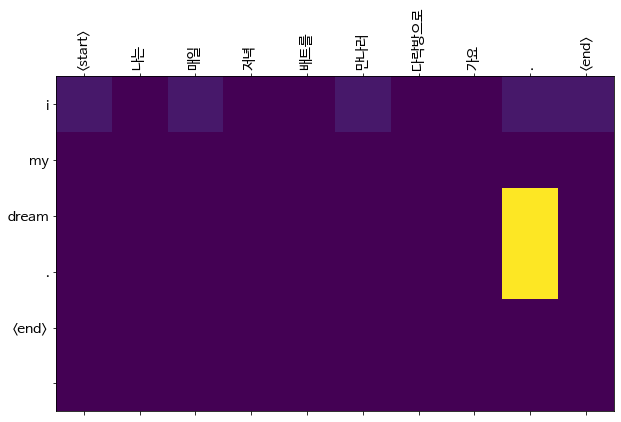

Input: <start> 선생님 이문장이 이해가 안 가요 . <end>
Predicted translation: i my friends . <end> 


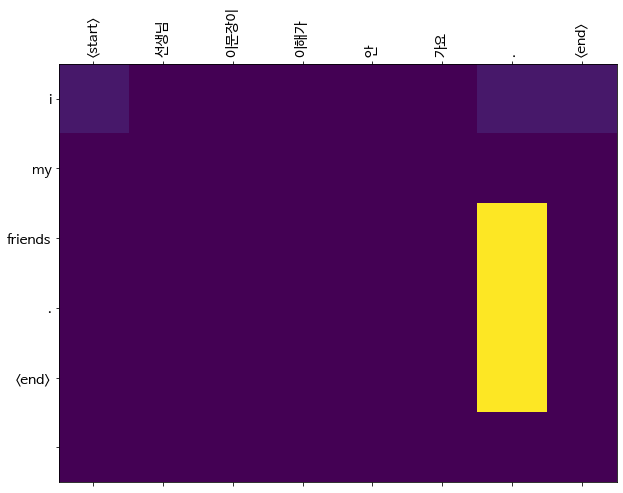

Input: <start> 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end>
Predicted translation: i my dream . <end> 


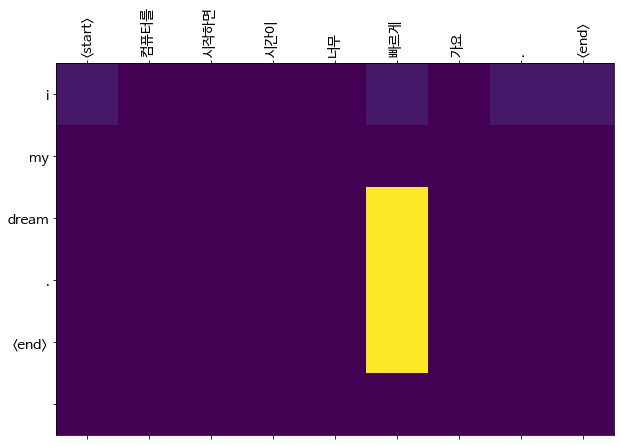

Input: <start> 나는 오늘 자정에 한국으로 돌아 가요 . <end>
Predicted translation: i my dream . <end> 


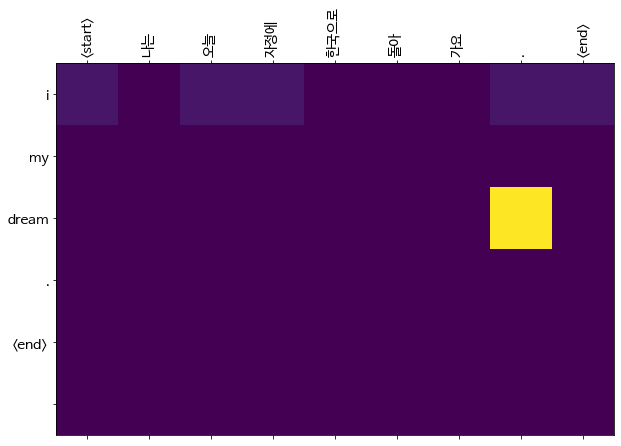

Input: <start> 나는 일어나자마자 화장실에 가요 . <end>
Predicted translation: i my friends . <end> 


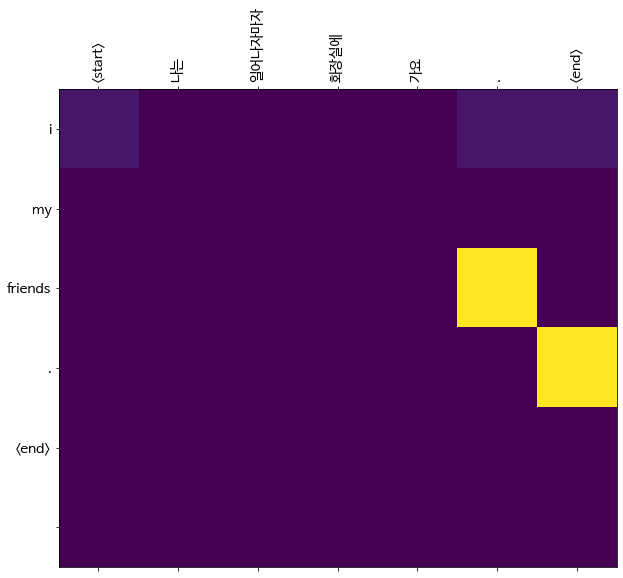

Input: <start> 지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . <end>
Predicted translation: i my friends . <end> 


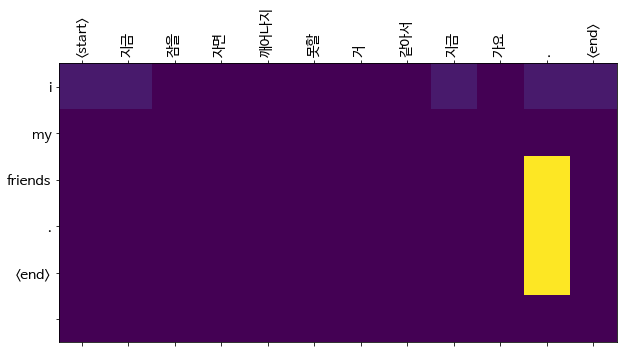

Input: <start> 학교가 끝나자마자 기숙사로 가요 . <end>
Predicted translation: i my dream . <end> 


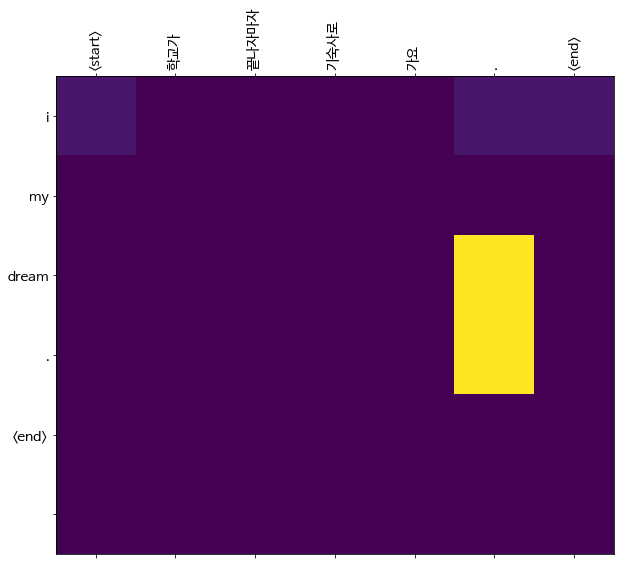

Input: <start> 대한민국 남자라면 모두 대에 의무적으로 군대에 가요 . <end>
Predicted translation: i my friends . <end> 


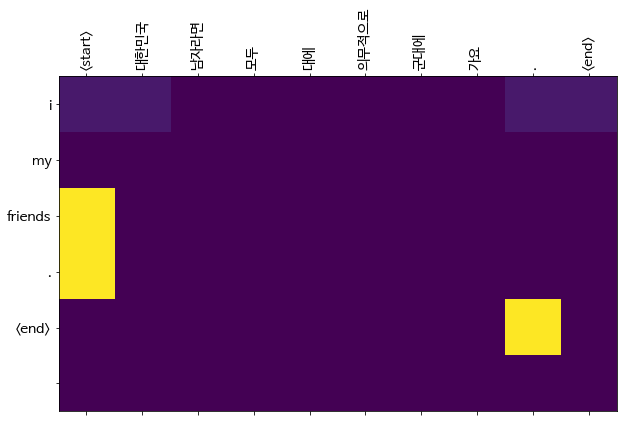

Input: <start> 오늘밤에 비자 때문에 한국에 가요 . <end>
Predicted translation: i my dream . <end> 


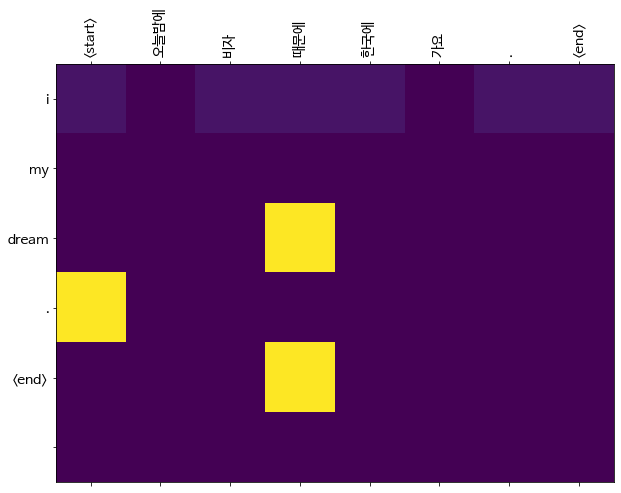

Input: <start> 오늘은 새 자동차를 받으러 가요 . <end>
Predicted translation: i my friends . <end> 


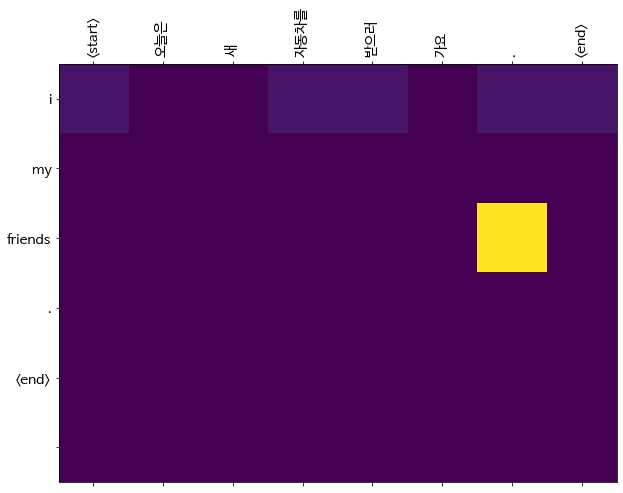

In [ ]:
# right order sentence, 2 layers Bidirectional LSTM with 1000 embedding_dims
for k in ko[:10]:
  kor=re.sub('<[^>]*>','',k)
  translate(kor)

Input: <start> . 가요 다락방으로 만나러 배트를 저녁 매일 나는 <end>
Predicted translation: i want can t do anything are now ? <end> 


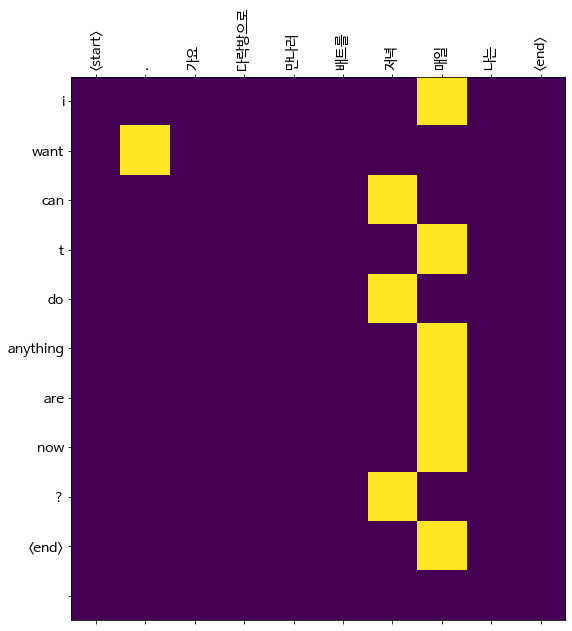

Input: <start> . 가요 안 이해가 이문장이 선생님 <end>
Predicted translation: i want to about the we are about to you a and can i ? <end> 


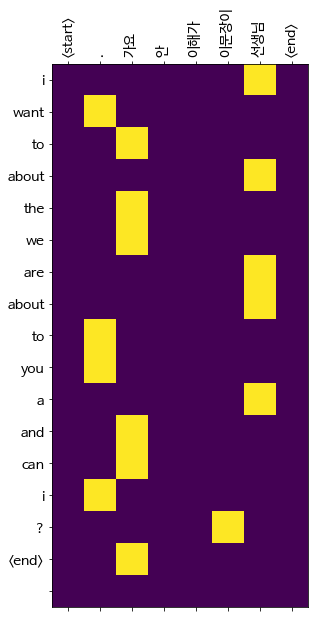

Input: <start> . 가요 빠르게 너무 시간이 시작하면 컴퓨터를 <end>
Predicted translation: i want to about the of when i is it ? <end> 


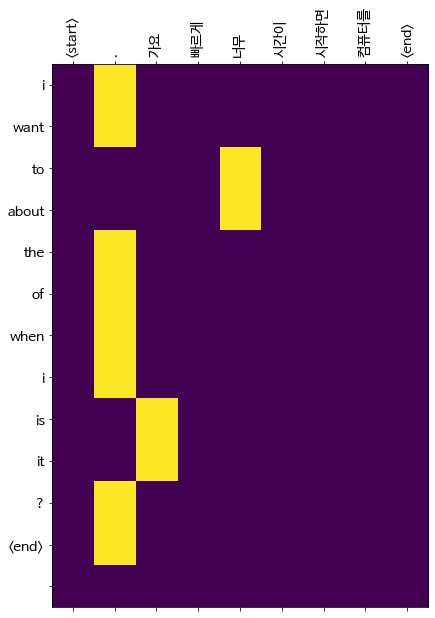

Input: <start> . 가요 돌아 한국으로 자정에 오늘 나는 <end>
Predicted translation: i want to about the room you about the we are really or are really also , <end> 


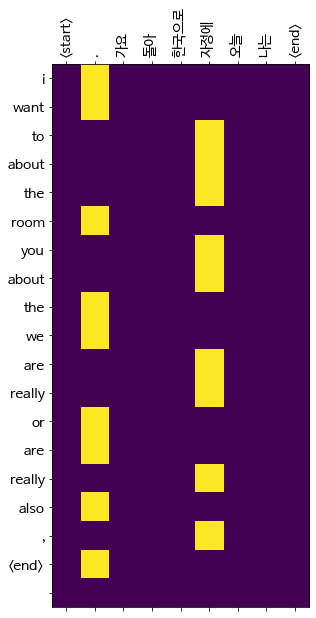

Input: <start> . 가요 화장실에 일어나자마자 나는 <end>
Predicted translation: i want to about the of when i is to do the is that i can t do the is that 


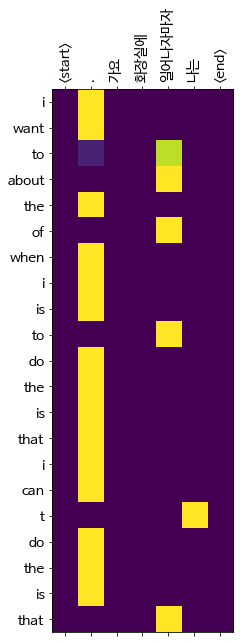

Input: <start> . 가요 지금 같아서 거 못할 깨어나지 자면 잠을 지금 <end>
Predicted translation: i want to about the we are about new can be ? <end> 


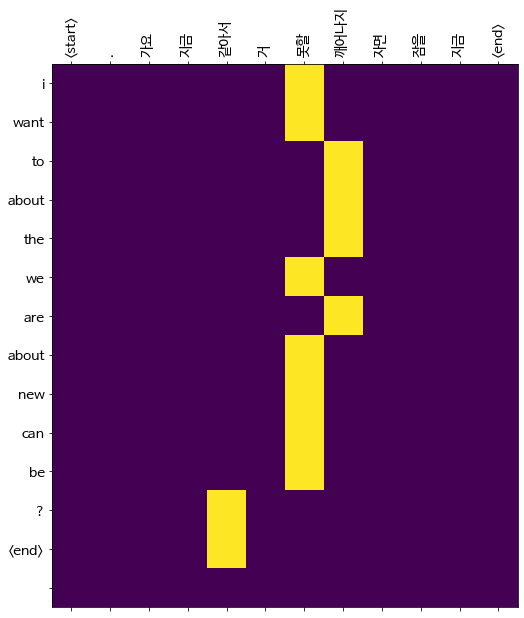

Input: <start> . 가요 기숙사로 끝나자마자 학교가 <end>
Predicted translation: i want to about the of when you , to you , to you , <end> 


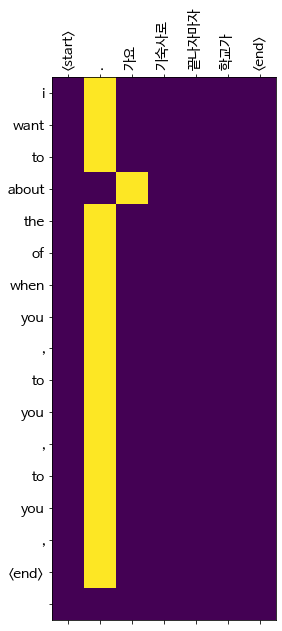

Input: <start> . 가요 군대에 의무적으로 대에 모두 남자라면 대한민국 <end>
Predicted translation: i want want to about <end> 


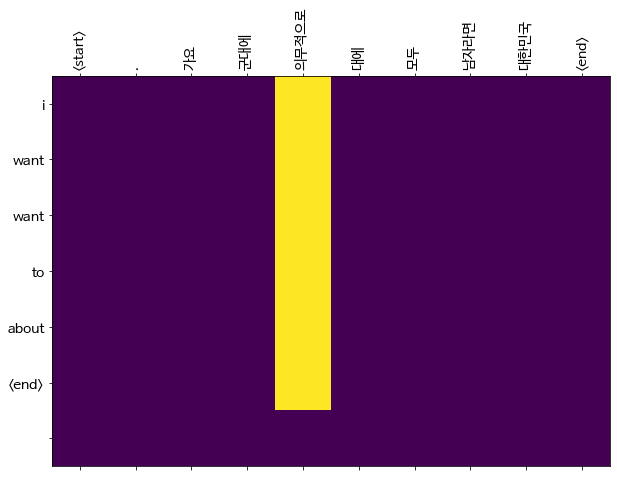

Input: <start> . 가요 한국에 때문에 비자 오늘밤에 <end>
Predicted translation: i want can t do anything today ? <end> 


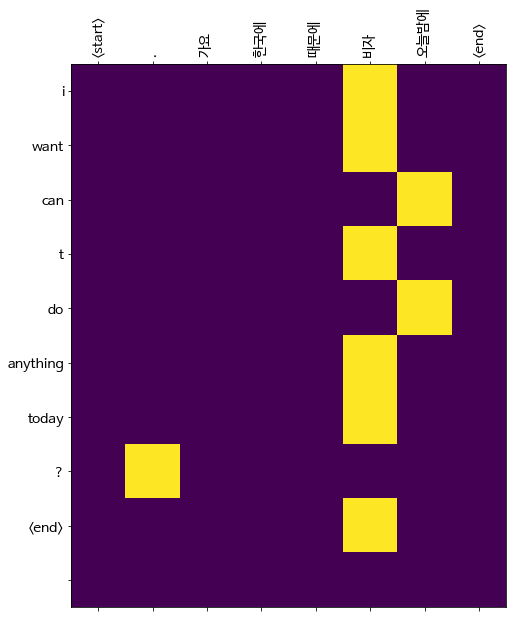

Input: <start> . 가요 받으러 자동차를 새 오늘은 <end>
Predicted translation: i want to about the we are about new ? <end> 


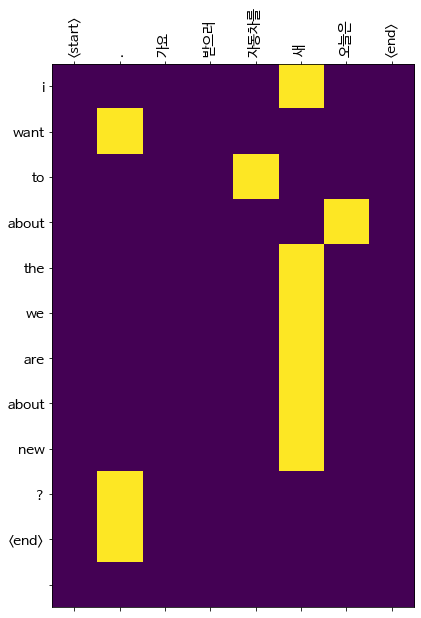

In [ ]:
# reverse sentece, 1 layers Bidirectional LSTM with 1000 embedding_dims
for k in ko[:10]:
  kor=re.sub('<[^>]*>','',k)
  translate(kor)

Input: <start> 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end>
Predicted translation: it even the the the the the the the the he he he . . . ! ! ! ! ! 


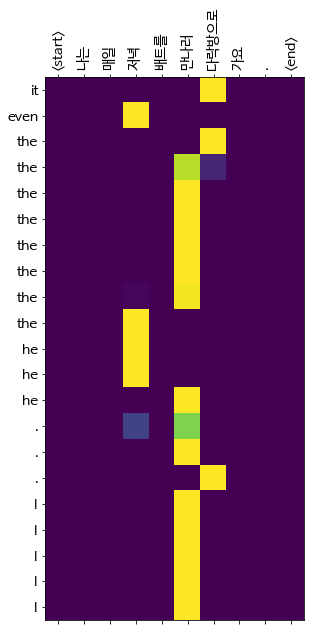

Input: <start> 선생님 이문장이 이해가 안 가요 . <end>
Predicted translation: it now the never the never the never the never the he they he they . . . . ! ! 


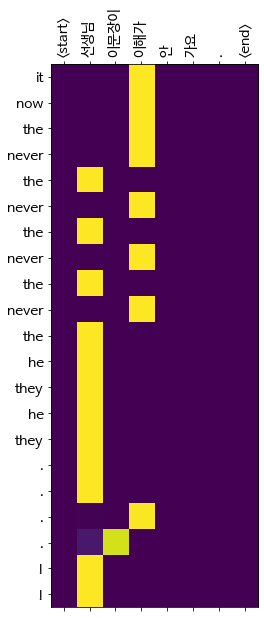

Input: <start> 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end>
Predicted translation: it don they the never the never the never the never the never . . ! ! ! ! ! ! 


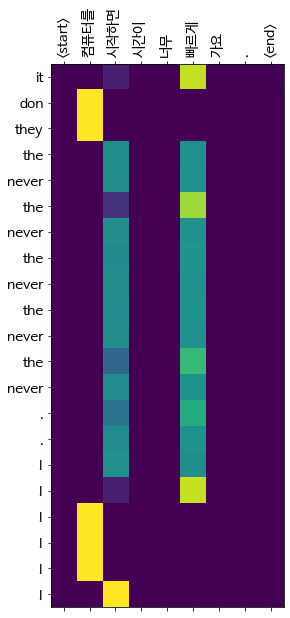

Input: <start> 나는 오늘 자정에 한국으로 돌아 가요 . <end>
Predicted translation: the they the the the the the the the the the the he they . . . ! days he they 


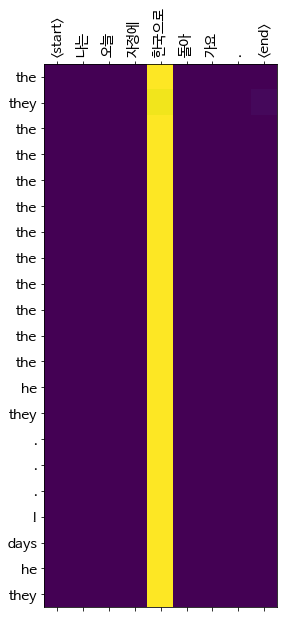

Input: <start> 나는 일어나자마자 화장실에 가요 . <end>
Predicted translation: the never the the the the the the the the the the never the never . . . ! ! ! 


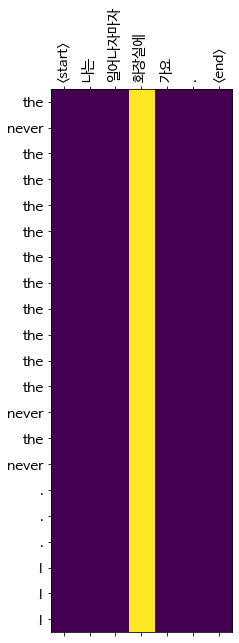

Input: <start> 지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . <end>
Predicted translation: it don the they the he the he they he he he . . . ! days he he he . 


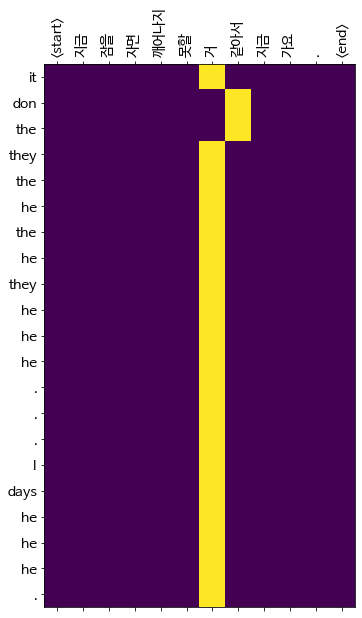

Input: <start> 학교가 끝나자마자 기숙사로 가요 . <end>
Predicted translation: it now the the the the the the the the the the the he he he . . . ! ! 


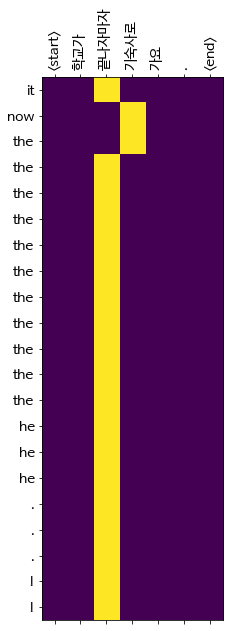

Input: <start> 대한민국 남자라면 모두 대에 의무적으로 군대에 가요 . <end>
Predicted translation: it even the the the the the the the they the he they . class they . class . class they 


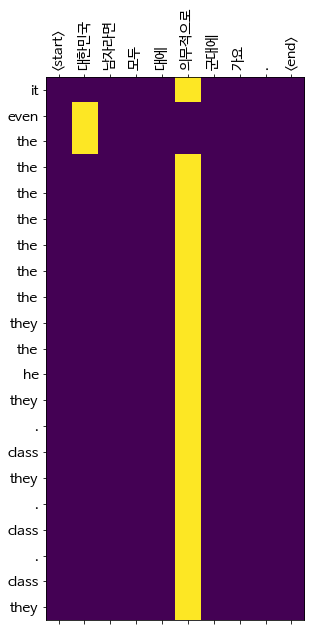

Input: <start> 오늘밤에 비자 때문에 한국에 가요 . <end>
Predicted translation: it now they the never the never the never the never the never he . ! ! ! ! ! ! 


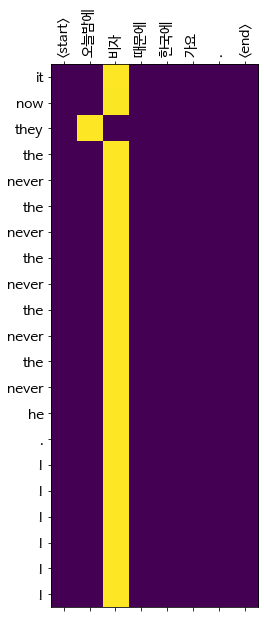

Input: <start> 오늘은 새 자동차를 받으러 가요 . <end>
Predicted translation: it now the they the they the they the they the they the he they . ! ! days they . 


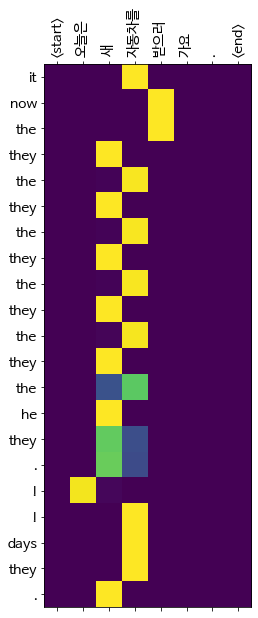

In [ ]:
# right order sentece, 1 layers Bidirectional LSTM with 1000 embedding_dims
for ko in ko[:10]:
  kor=re.sub('<[^>]*>','',ko)
  translate(kor)

Input: <start> 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end>
Predicted translation: as an adult . <end> 


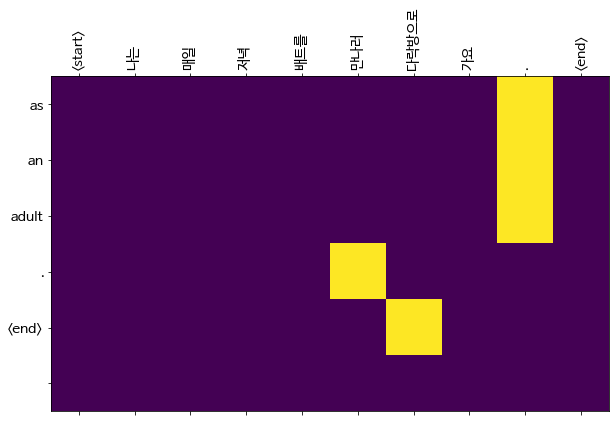

Input: <start> 선생님 이문장이 이해가 안 가요 . <end>
Predicted translation: we also it s not that place , but it , but it , but it , but it , but 


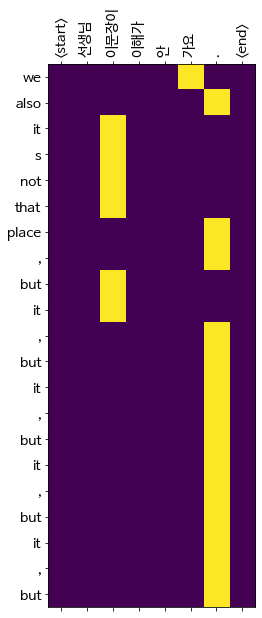

Input: <start> 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end>
Predicted translation: but it , it is to , but it , but it , but it , but it , but it 


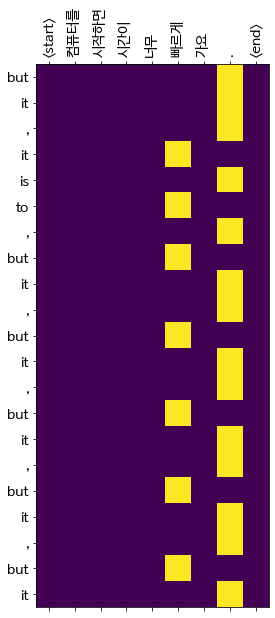

Input: <start> 나는 오늘 자정에 한국으로 돌아 가요 . <end>
Predicted translation: today , it is because my mother s not that place , but it , but can we meet me , 


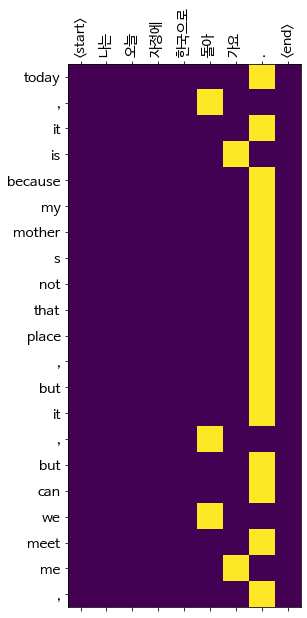

Input: <start> 나는 일어나자마자 화장실에 가요 . <end>
Predicted translation: we had here but it , but it , but it , but it , but it , but it , 


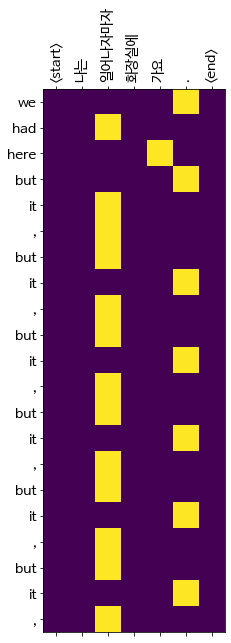

Input: <start> 지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . <end>
Predicted translation: we also an opportunity to us this to us this to eat together to the philippines today s morning but that 


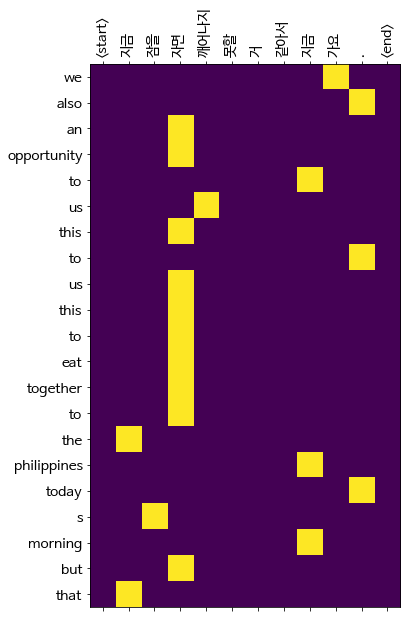

Input: <start> 학교가 끝나자마자 기숙사로 가요 . <end>
Predicted translation: we also it was so just not that korean food is important . <end> 


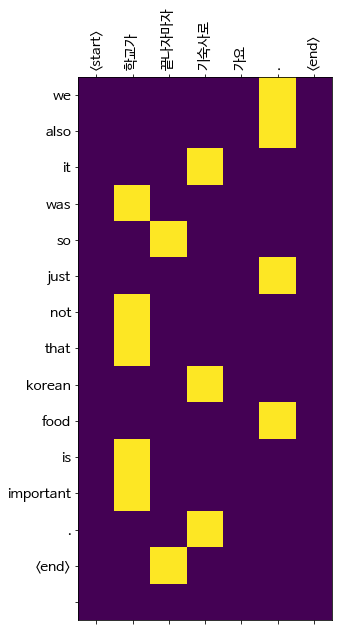

Input: <start> 대한민국 남자라면 모두 대에 의무적으로 군대에 가요 . <end>
Predicted translation: we also it s not that place , but it , but it , but it , but it , but 


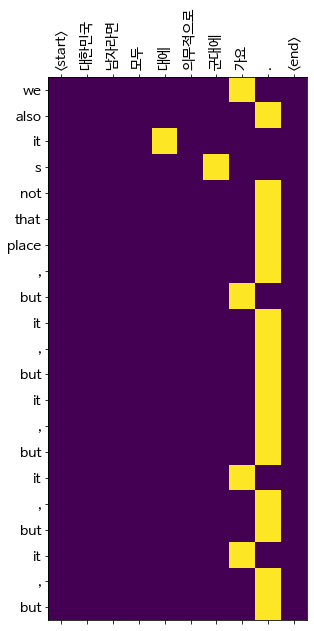

Input: <start> 오늘밤에 비자 때문에 한국에 가요 . <end>
Predicted translation: we had to take the test here . <end> 


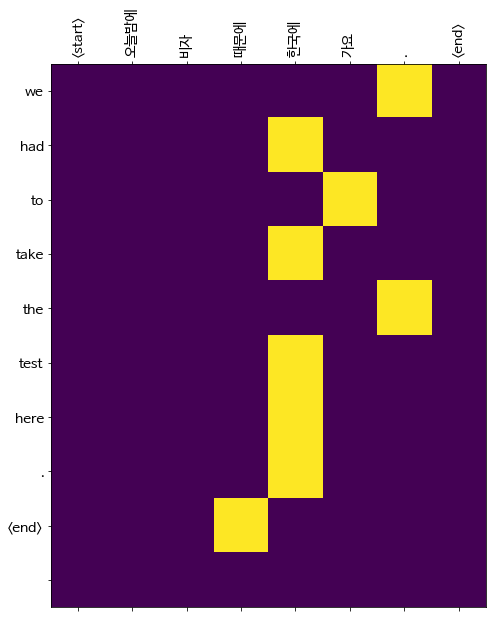

Input: <start> 오늘은 새 자동차를 받으러 가요 . <end>
Predicted translation: we also year is also is also is that i couldn t sleep at this is also is also is also 


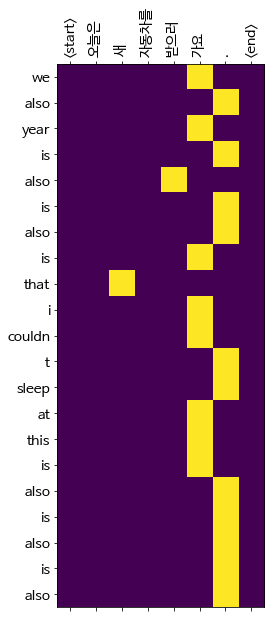

In [ ]:
# reverse sentece, 2 layers Bidirectional LSTM with 1000 embedding_dims
for ko in ko[:10]:
  kor=re.sub('<[^>]*>','',ko)
  translate(kor)

Input: <start> . 가요 다락방으로 만나러 배트를 저녁 매일 나는 <end>
Predicted translation: like s s a person has class s s s class s a job s s work and and and and 


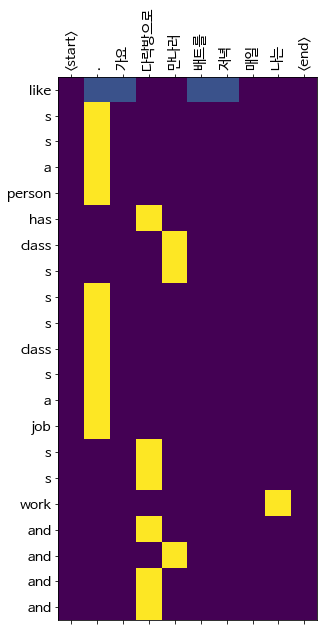

Input: <start> . 가요 안 이해가 이문장이 선생님 <end>
Predicted translation: like s why we didn t we were too s s s s s s schedule were good . <end> 


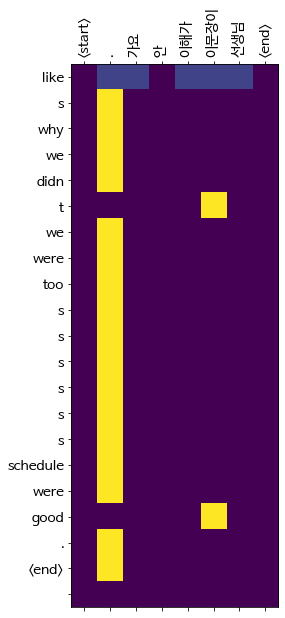

Input: <start> . 가요 빠르게 너무 시간이 시작하면 컴퓨터를 <end>
Predicted translation: you and it seems like you you you you you you you you you you you you you you you you 


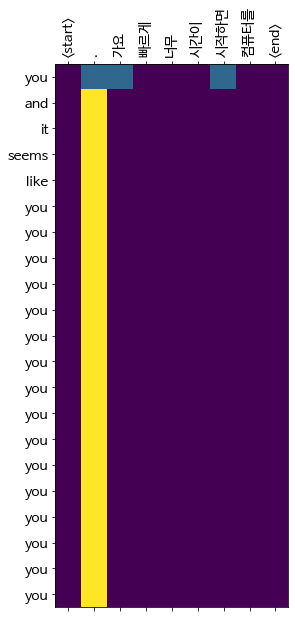

Input: <start> . 가요 돌아 한국으로 자정에 오늘 나는 <end>
Predicted translation: did you tell we same we same we same we same we same we same we same we same we same 


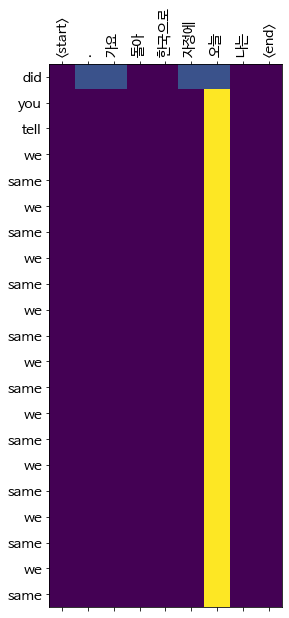

Input: <start> . 가요 화장실에 일어나자마자 나는 <end>
Predicted translation: like s s a person you you tell it you you you you you you you you you you you you 


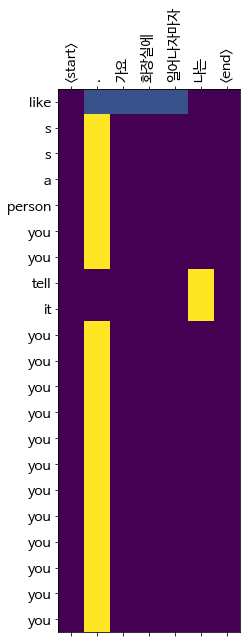

Input: <start> . 가요 지금 같아서 거 못할 깨어나지 자면 잠을 지금 <end>
Predicted translation: you you you you you you you you you you you you you you you you you you you you you 


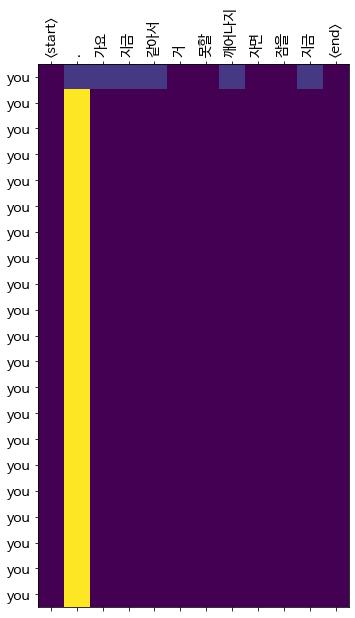

Input: <start> . 가요 기숙사로 끝나자마자 학교가 <end>
Predicted translation: like s s a person has we same phone . <end> 


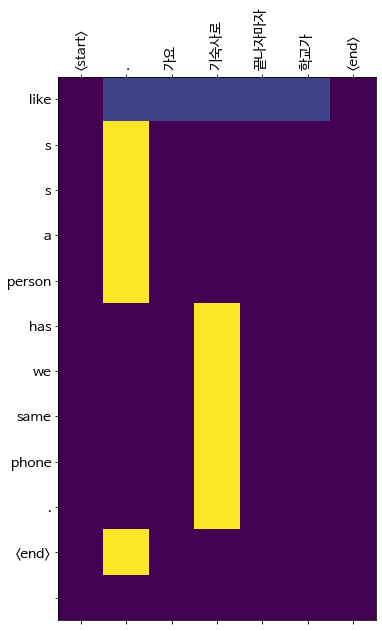

Input: <start> . 가요 군대에 의무적으로 대에 모두 남자라면 대한민국 <end>
Predicted translation: like s s a person you you you you you you you you you you you you you you you you 


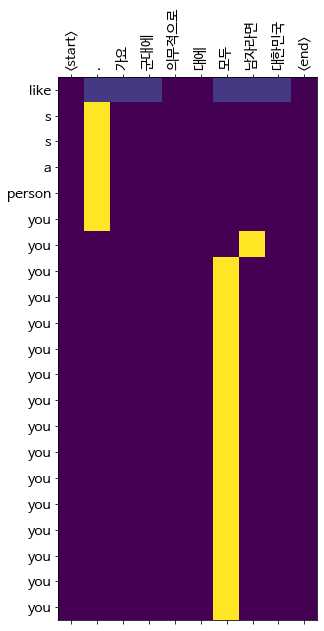

Input: <start> . 가요 한국에 때문에 비자 오늘밤에 <end>
Predicted translation: like at s why we were too s s s s s best friend s best like you you you you 


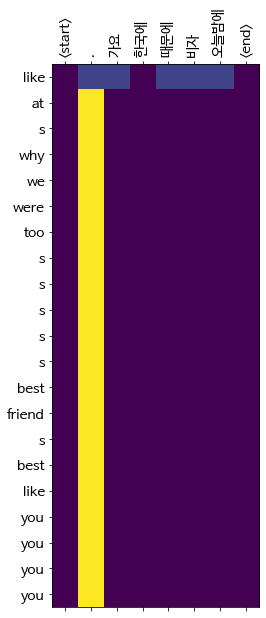

Input: <start> . 가요 받으러 자동차를 새 오늘은 <end>
Predicted translation: you ll we same friend it a month and a month and a month and a month and a month and 


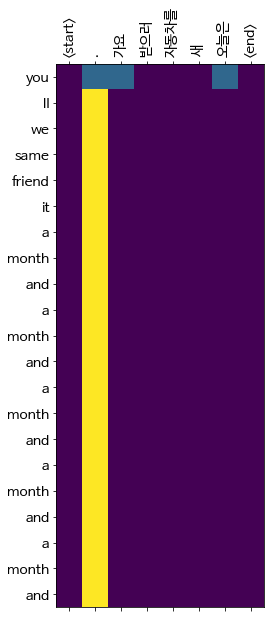

In [ ]:
# reverse sentece, 3 layers Bidirectional LSTM with 500 embedding_dims
for ko in ko[:10]:
  kor=re.sub('<[^>]*>','',ko)
  translate(kor)

In [ ]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_avg(doc, target_doc):
  bleu_score=[]
  smoothie = SmoothingFunction().method4
  for input_sentence, target_sentence in tqdm(zip(doc,target_doc)):
    try:
      input_sentence=re.sub('<[^>]*>','',input_sentence)
      target_sentence=re.sub('<[^>]*>','',target_sentence)
      result, sentence, attention_plot = evaluate(input_sentence)
      bleu_score.append(nltk.translate.bleu_score.sentence_bleu(target_sentence.split(' '),
                                                                result.split(' '),smoothing_function=smoothie))
    except:
      pass
  return np.mean(bleu_score)


In [ ]:
# right order sentece, 1 layers Bidirectional LSTM with 1000 embedding_dims
bleu_avg(ko[63001:],en[63001:])

0.17252454503274248

In [ ]:
# reverse order sentece, 1 layers Bidirectional LSTM with 1000 embedding_dims
bleu_avg(ko[63001:],en[63001:])

0.19913371436160368

In [ ]:
# right order sentece, 2 layers Bidirectional LSTM with 1000 embedding_dims
bleu_avg(ko[63001:],en[63001:])

0.22938764631821015